#Lab 7: Training neural networks (part 2)
**Like always, remember to set Runtime environment to GPU**

In this lab we will explore more tools that will help you train your own neural networks. This time we will be using convolutional neural networks (CNNs).


##1. Download the CIFAR 10 dataset
We will be using the CIFAR 10 dataset.

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

mean = 0.5
std = 0.5
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((mean, mean, mean), (std, std, std))])

# Batch size
bs = 64

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=bs,
                                          shuffle=True, num_workers=2,drop_last=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=bs,
                                         shuffle=False, num_workers=2,drop_last=True)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [00:03<00:00, 47650849.36it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Display some stats

num_train 49984
num_test 9984
images.shape torch.Size([64, 3, 32, 32])


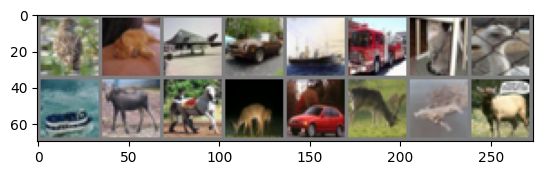

 bird   cat plane   car  ship truck   cat  bird  ship  deer horse  deer   car  deer plane  deer


In [2]:
import matplotlib.pyplot as plt
import numpy as np

# Function to show an image
def imshow(img):
    npimg = img.numpy() / 2 + 0.5 # Un-normalize
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Number of samples
num_train = bs * len(trainloader)
num_test = bs * len(testloader)
print('num_train',num_train)
print('num_test',num_test)

# Get a batch of some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)
print('images.shape',images.shape)

# show 16 images and print labels
imshow(torchvision.utils.make_grid(images[0:16]))
print(' '.join('%5s' % classes[labels[j]] for j in range(16)))

## 2. Task 1 (optional): Setting up your CNN
**You can skip this task and jump directly to Task 2, if you feel comfortable with PyTorch and the different layer types used in CNNs.**

Here, we will set up our own CNN. For this purpose we will need the following layer types:

- [Conv2d](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html#torch.nn.Conv2d)
- [MaxPool2d](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html#torch.nn.MaxPool2d)
- [BatchNorm2d](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html#torch.nn.BatchNorm2d)
- [ReLU](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html#torch.nn.ReLU)
- [Dropout](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html#torch.nn.Dropout)
- [Linear](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html#torch.nn.Linear])

as well as the reshape operation (called `view` in PyTorch):

- [view](https://pytorch.org/docs/stable/generated/torch.Tensor.view.html#torch.Tensor.view)

See complete overview of the basic building block for graphs [here](https://pytorch.org/docs/stable/nn.html).

Let's see how each of these work:

In [3]:
# First import what we need
import torch.nn as nn
import torch.nn.functional as F

**Side-note:** What's the difference between torch.nn and torch.nn.functional? Read [here](https://discuss.pytorch.org/t/what-is-the-difference-between-torch-nn-and-torch-nn-functional/33597/7)

###2.1 Conv2d
Reference to documentation: https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html#torch.nn.Conv2d

In [4]:
# Print shape of input
print('Input dimensions are (batch_size, channels, height, width)')
print('images.shape',images.shape)

# Perform convolution
conv = nn.Conv2d(3, 6, 5)
x = conv(images)

# Print shape of output
print('x.shape',x.shape)

# Print parameter shapes
for name, param in conv.named_parameters(): print('parameter',name,param.shape)

Input dimensions are (batch_size, channels, height, width)
images.shape torch.Size([64, 3, 32, 32])
x.shape torch.Size([64, 6, 28, 28])
parameter weight torch.Size([6, 3, 5, 5])
parameter bias torch.Size([6])


####2.1.1 Questions
1. What do each of the parameters (3, 6, 5) mean?
2. Recall the formula to calculate the output size of a convolution:

 `output_size = (input_size - kernel_size) / stride + 1`

 or as defined in the slides of Lecture 4:

 `output_size = (N - W) / stride + 1`

 Is this formula satisfied in the above example?
3. How could you make the output (x) have the same width and height as the input (images)? (Think "padding"...)
4. If the convolution operation performed above was a layer in a CNN, what would the number of parameters of that layer be?

####2.1.2 Answers
1. `(in_channels, out_channels, kernel_size) = (3, 6, 5)`, where `in_channels` is the number of channels of the input (3 here because input is a color image), `out_channels` is the number of feature meaps that will be generated, and `kernel_size` is the filter size. It is common practise to use the names of the arguments, like this:

 `conv = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5)`
2. Yes. We have `N = input_size = 32`, `W = kernel_size = 5`, `stride = 1` (default), so theoretically `output_size = (32-5)/1 + 1 = 28`, which matches the shape of `x`.
3. `Conv2d` has a padding option. By setting `padding = 2`, the output gets the same width/height as the input (see code below). The formula for calculating the right padding size is (see slides from lecture 5): `padding = (W-1)/2 = (5-1)/4 = 2`.
4. For the filter weights the number of parameters is `out_channels * in_channels * kernel_size^2 = 6 * 3 * 5 * 5 = 450`. In addition there is one bias parameters for each output, totalling `450 + 6 = 456` parameters.

In [5]:
# Code for question 2: Padding
conv = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, padding=2)
x = conv(images)

# Width and height are the same
print('x.shape',x.shape)
print('images.shape',images.shape)

x.shape torch.Size([64, 6, 32, 32])
images.shape torch.Size([64, 3, 32, 32])


###2.2 MaxPool2d
Reference to documentation: https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html#torch.nn.MaxPool2d

In [6]:
# Random input - dimensions are (batch_size, channels, height, width)
x = torch.randn(64,6,28,28)

# Perform max pool
pool = nn.MaxPool2d(2, 2)
y = pool(x)
print('y.shape',y.shape)

# Print some elements
print('x[0,0,0:4,0:4]:\n',x[0,0,0:4,0:4])
print('y[0,0,0:2,0:2]:\n',y[0,0,0:2,0:2])

y.shape torch.Size([64, 6, 14, 14])
x[0,0,0:4,0:4]:
 tensor([[-0.4166,  0.4223, -1.7194,  2.2191],
        [-0.5273, -0.7090,  0.8581, -0.7844],
        [-0.7377,  0.7506, -0.2305,  0.4925],
        [ 0.9827,  0.5348,  0.6515,  0.6647]])
y[0,0,0:2,0:2]:
 tensor([[0.4223, 2.2191],
        [0.9827, 0.6647]])


####2.2.1 Questions
1. What does MaxPool2d do? (Explain the output `y[0,0,0:2,0:2]` and compare to `x[0,0,0:2,0:2]`)
2. What do each of the parameters (2, 2) mean?

####2.2.2 Answers
1. It downscales the input along the widht and height dimensions. It does so by running a "window" over the input. For each window it outputs the maximum value within the window. In the example above, the window size is 2x2, and the window is shifted to pixels. Hence, the output `y` is half the width/height of the input `x`, and the output values are the maxima of the corresponding window of the input.
2. The first parameter is the window size (or kernel_size), and the second parameter is the stride (i.e., how many pixel the window position is shifted).

###2.3 BatchNorm2d
Reference to documentation: https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html#torch.nn.BatchNorm2d

In [7]:
# Random input - dimensions are (batch_size, channels, height, width)
x = torch.randn(64,6,28,28)*10 + 2
print('x.mean',x.mean())
print('x.std',x.std())

# Perform batch normalization
bn = nn.BatchNorm2d(6)
y = bn(x)
print('y.mean',y.mean())
print('y.std',y.std())

# Print parameter shapes
for name, param in bn.named_parameters(): print('parameter',name,param.shape)

x.mean tensor(1.9847)
x.std tensor(10.0045)
y.mean tensor(1.0644e-09, grad_fn=<MeanBackward0>)
y.std tensor(1.0000, grad_fn=<StdBackward0>)
parameter weight torch.Size([6])
parameter bias torch.Size([6])


####2.3.1 Questions
1. What does BacthNorm2D do?
2. What does the input parameter (6) mean?
3. Is the mean and standard deviation after batch normalization as expected?
4. How many parameters does BatchNorm2D have? Why?

####2.3.2 Answers
1. For each batch, it normalizes the values of the input according to the equation found in the documentation (and slides of lecture 6). The normalization is based on a standard score `y=(x-mean(x))/std(x)`, with the addition of two *learnable* parameters that can revert the standard score to produce the identity function if necessary. So the final equation becomes `y = gamma*(x-mean(x))/std(x) + beta` and with `gamma=std(x)` and `beta=mean(x)`, we get the identity function `y=x`. The initial values of the parameters are `gamma=1` and `beta=0`.
2. It is `num_features` corresponding to `C` with an expected input of size `(N, C, H, W)`.
3. The mean and standard deviation of output `y` should be 0 and 1, respectively. That seems to be the case.
4. It has 2x6: a gamma and a beta for each input channel.

###2.4 ReLU
Reference to documentation: https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html#torch.nn.ReLU

In [8]:
# Random input - dimensions are (batch_size, channels, height, width)
x = torch.randn(64,6,28,28)
print('x.min',x.min())
print('x.max',x.max())
print('x[0,0,0:4,0:4]:\n',x[0,0,0:4,0:4])

# Apply ReLU
y = F.relu(x)
print('y.min',y.min())
print('y.max',y.max())
print('y[0,0,0:4,0:4]:\n',y[0,0,0:4,0:4])

x.min tensor(-4.5569)
x.max tensor(4.6400)
x[0,0,0:4,0:4]:
 tensor([[-0.6614, -0.8175, -2.2756,  0.4610],
        [-0.1693,  0.3815,  0.4999, -0.1391],
        [-1.2133,  0.6698,  0.2650, -1.0761],
        [-0.8905, -0.5833, -0.3422, -0.4910]])
y.min tensor(0.)
y.max tensor(4.6400)
y[0,0,0:4,0:4]:
 tensor([[0.0000, 0.0000, 0.0000, 0.4610],
        [0.0000, 0.3815, 0.4999, 0.0000],
        [0.0000, 0.6698, 0.2650, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000]])


####2.4.1 Question
1. What does ReLU do? (Explain the output `y[0,0,0:4,0:4]` and compare to `x[0,0,0:4,0:4]`)

####2.4.2 Answers
1. It sets all negative values to zero. That's it.

###2.5 Linear and view
Reference to documentation:
- https://pytorch.org/docs/stable/generated/torch.nn.Linear.html#torch.nn.Linear
- https://pytorch.org/docs/stable/generated/torch.Tensor.view.html#torch.Tensor.view

Recall that CNNs for classification are divided into two blocks:

1. **Convolutional base (encoder):** A sequence of convolutional layers resulting in a feature map that you may think of as a multi-dimensional image with a certain width, height, and depth (number of channels).
2. **Fully connected layers (decoder):** One or more fully connected layers ending with a classifier.

The input to the decoder has to be a vector with the correct dimensions. Thus, our task is to convert the feature map into a vector. In the code below we wish to take the feature map `x`, vectorize it, and feed it through a fully connected layer to produce 10-dimensional output.

Your task is to figure out, what value `N` should have (see helper questions below):

In [9]:
# Random input - dimensions are (batch_size, channels, height, width)
x = torch.randn(64,6,28,28)

N = 6*28*28 # Solution

# Vectorize
y = x.view(-1, N)
print('y.shape',y.shape)

# Fully connected layer
fc = nn.Linear(N,10)
z = fc(y)
print('z.shape',z.shape)

y.shape torch.Size([64, 4704])
z.shape torch.Size([64, 10])


The correct output shape (of z) is [64, 10], where 64 is the batch size and 10 is the dimensionality we want in the output side of the fully connected layer.

####2.5.1 Helper questions
1. What does `view` do?
2. What does `Linear` do?


####2.5.2 Answers
1. `view` returns a new tensor with the same data as the input tensor but of a different shape. Our input has shape `(64,6,28,28)`, where the dimensions are `(batch_size, channels, height, width)`. When vectorizing this, we want to keep the batch dimensions, so the output should have size `(64,6*28*28)`, so `N = 6*28*28 (= 4704)`.
2. `Linear` applies a linear transformation to the incoming data: `y = Wx + b`, where `x` has shape `(batch_size, in_features)`, and the output has shape `(batch_size, out_features)`. Therefore, the parameters of `Linear` are `(in_features, out_features)`. Here we have `in_features = N = 6*28*28`.


##2.6 Dropout
Reference to documentation: https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html#torch.nn.Dropout

Dropout is normally used only in relation to fully connected layers (i.e., not convolutional layers). The example below demonstrates the effect of the Dropout layer:

In [10]:
# Random input - dimensions are (batch_size, num_in_features)
x = torch.randn(64,10)
print('x[0,:]',x[0,:])

drop = nn.Dropout(p=0.5)
y = drop(x)
print('y[0,:]',y[0,:])

print('ratios',y[0,:]/x[0,:])

x[0,:] tensor([ 0.9895,  0.8189,  1.1346,  3.0995, -0.2430,  0.3932,  0.1584, -0.2556,
        -2.3609, -0.8223])
y[0,:] tensor([ 1.9791,  0.0000,  0.0000,  0.0000, -0.0000,  0.0000,  0.3168, -0.0000,
        -0.0000, -1.6447])
ratios tensor([2., 0., 0., 0., 0., 0., 2., 0., 0., 2.])


**IMPORTANT NOTE:** If necessary, re-run the code block until the printed part of `y[0,:]` contains both zeros and non-zeroes.

####2.6.1 Questions
1. Explain why there are zeroes in `y`.
2. Ratios: Why are the values of the non-zero entries of `y` twice as large as the corresponding values of the input `x`?
3. What happens to the ratios if you set `p=0.75`?

####2.6.2 Answers
1. Applying Dropout has the affect of setting elements to zero with a certain probability `p`. In other words the output `y` will be identical to input `x`, except that a fraction `p` of the elements (roughly) are set to zero.
2. When using Dropout in the context of a neural network, we apply Dropout only during training, but not during testing/evaluation. So if `p=0.5` half of the neurons will be inactive during training, but not during testing. To compensate for this, we can scale the output `y` by `1/(1-p)` during training. In this example `1/(1-p) = 1/0.5 = 2`, so the non-zero elements of `y` are twice is large as the corresponding elements of input `x`.
3. The ratios become `4` instead of `2`(see code below) because `1/(1-0.75) = 1/0.25 = 4`.

In [11]:
# Setting p = 0.75, the ratio becomes 4
drop = nn.Dropout(p=0.75)
y = drop(x)
print('ratios',y[0,:]/x[0,:])

ratios tensor([0., 0., 0., 0., 0., 4., 4., 0., 0., 0.])


##2.7 Setting up the model
Your task is to fill in the blanks (???) below.

Hint: You can insert print statements in the `forward` function, which is executed when calling `scores = model(images)`.

In [12]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, stride=1, padding=0)
        self.bn1 = nn.BatchNorm2d(num_features=6)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        self.bn2 = nn.BatchNorm2d(num_features=16) # num_features = 16 because conv2 has out_channels = 16
        self.drop = nn.Dropout(p=0.5)
        self.fc1 = nn.Linear(in_features=16*5*5, out_features=120) # in_features = 16*5*5 because output shape of previous layer is 16x5x5 (see code below)
        self.fc2 = nn.Linear(in_features=120, out_features=10) # in_features = 120 because out_features of previous layer is 120

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.pool(x)
        x = x.view(-1, 16*5*5) # 16*5*5 because input shape is 16 x 5 x 5
        x = self.drop(x)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x

model = Net()

print('Network architecture:\n')
print(model)

# Print parameter shapes
print('Network parameters:\n')
for name, param in model.named_parameters(): print('parameter',name,param.shape)

# Test model
scores = model(images)
print(scores.shape)

Network architecture:

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (bn1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (drop): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=10, bias=True)
)
Network parameters:

parameter conv1.weight torch.Size([6, 3, 5, 5])
parameter conv1.bias torch.Size([6])
parameter bn1.weight torch.Size([6])
parameter bn1.bias torch.Size([6])
parameter conv2.weight torch.Size([16, 6, 5, 5])
parameter conv2.bias torch.Size([16])
parameter bn2.weight torch.Size([16])
parameter bn2.bias torch.Size([16])
parameter fc1.weight torch.Size([120, 400])
parameter fc1.bias torch.Size([120])
parame

Example code to find shape of input to first fully connected layer:

In [13]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, stride=1, padding=0)
        self.bn1 = nn.BatchNorm2d(num_features=6)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        self.bn2 = nn.BatchNorm2d(num_features=16) # num_features = 16 because conv2 has out_channels = 16
        self.drop = nn.Dropout(p=0.5)
        #self.fc1 = nn.Linear(in_features=???, out_features=120) # in_features = 16*5*5 because output shape of previous layer is 16x5x5 (see code below)
        #self.fc2 = nn.Linear(in_features=???, out_features=10) # in_features = 120 becuase out_features of previous layer is 120

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.pool(x)
        print(x.shape)
        #x = x.view(-1, ???)
        #x = self.drop(x)
        #x = self.fc1(x)
        #x = F.relu(x)
        #x = self.fc2(x)
        return x

model = Net()

# Test model
x = model(images)
print(x.shape)

torch.Size([64, 16, 5, 5])
torch.Size([64, 16, 5, 5])


##3. Task 2: Training the model
In this task, just run the code, observe what happens and do your best to understand it.

In [14]:
# First import what we need
import torch.nn as nn
import torch.nn.functional as F

###3.1 Setting up the CNN model
First, lets set up a simple CNN with 2 convolutional layers, followed by two fully connected layers. The network is equivalent to the network defined above in Task 1. Each convolution operation is followed by batch normalization, ReLU, and max pooling (Note that instead of max pooling we could also have applied convolution with a stride of 2 to achieve the same level of down-sizing). The self-made Lambda layer helps us reshape the output of the last conv layer to a vector, because PyTorch has no built-in reshape layer. We perform dropout on this vector with p = 0.5, before applying the two fully connected layers.

In [15]:
class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func

    def forward(self, x):
        return self.func(x)

def Net():
  net = nn.Sequential(
      nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, stride=1, padding=0),
      nn.BatchNorm2d(num_features=6),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2, stride=2),
      nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5),
      nn.BatchNorm2d(num_features=16),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2, stride=2),
      Lambda(lambda x: x.view(x.size(0), -1)), # Vectorize
      nn.Dropout(p=0.5),
      nn.Linear(in_features=16*5*5,out_features=120),
      nn.ReLU(),
      nn.Linear(in_features=120, out_features=10)
  )
  return net

model = Net()

print('Network parameters:\n')
print(model)

# Print parameter shapes
for name, param in model.named_parameters(): print('parameter',name,param.shape)

Network parameters:

Sequential(
  (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): ReLU()
  (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (8): Lambda()
  (9): Dropout(p=0.5, inplace=False)
  (10): Linear(in_features=400, out_features=120, bias=True)
  (11): ReLU()
  (12): Linear(in_features=120, out_features=10, bias=True)
)
parameter 0.weight torch.Size([6, 3, 5, 5])
parameter 0.bias torch.Size([6])
parameter 1.weight torch.Size([6])
parameter 1.bias torch.Size([6])
parameter 4.weight torch.Size([16, 6, 5, 5])
parameter 4.bias torch.Size([16])
parameter 5.weight torch.Size([16])
parameter 5.bias torch.Size([16])
parame

Here is a useful function that you can call to re-initialize the weights/parameters of the model:

In [16]:
def reset_parameters(net):
    '''Init layer parameters.'''
    for m in net.modules():
        if isinstance(m, nn.Conv2d):
            torch.nn.init.kaiming_normal_(m.weight)
            if m.bias is not None:
                torch.nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.BatchNorm2d):
            torch.nn.init.constant_(m.weight, 1) # Why 1? Gamma = scaling = 1
            torch.nn.init.constant_(m.bias, 0) # Why 0? Beta = offset = 0
        elif isinstance(m, nn.Linear):
            torch.nn.init.kaiming_normal_(m.weight)
            if m.bias is not None:
                torch.nn.init.constant_(m.bias, 0)

reset_parameters(model)

###3.2 Testing the model
Let's test the model:

In [17]:
# Move data to GPU
images = images.cuda()
labels = labels.cuda()

# Calculate scores
model = Net().cuda()
scores = model(images)  # predictions

print(scores.shape)

torch.Size([64, 10])


###3.3 Calculating the accuracy
The scores (logits) don't have any meaningful interpretation, but we can convert them into class probabilities using softmax. Since we are only going to be interested in the model's accuracy, we will wrap the softmax inside function accuracy that calculates the accuracy on a batch:

In [18]:
def accuracy(scores, yb):
    score2prob = nn.Softmax(dim=1)
    preds = torch.argmax(score2prob(scores), dim=1)
    return (preds == yb).float().mean()

print('Accuracy', accuracy(scores,labels))

Accuracy tensor(0.0156, device='cuda:0')


###3.4 Calculating the loss
I order to train your model, we also need a loss function. We will use the cross entropy loss already provided in PyTorch:

In [19]:
loss_func = F.cross_entropy
loss = loss_func(scores, labels)
print('Loss', loss)

Loss tensor(2.4814, device='cuda:0', grad_fn=<NllLossBackward0>)


###3.5 Training function (fit)
The code below can be used to train a model and monitor important stats as training progresses. The training is carried out by calling the `fit` function, which takes any model as input.

You can change the optimizer by replacing `base_optimizer` with your own function handle.

The function `base_lr_scheduler` is a learning rate scheduler that updates the learning rate of the optimizer during training. The dummy-implementation does nothing, but you can modify it to implement your own learning rate scheduler. The inputs are
- `T` : Total number of batches
- `t` : Current batch index (max(t) = T)
- `lr` : Current learning rate

Other parameters to `fit` are:
- `bs` the batch size
- `epochs` the number of epochs
- `batches_per_epoch` the number of batches per epoch. If set to `None`, all images in the dataset are used.

Note that you can use `batches_per_epoch` to reduce the size of the training set. The effective size of the training set is `bs*batches_per_epoch`.

In [20]:
from torch import optim

# Function handle that returns an optimizer
def base_optimizer(model,lr=0.001, momentum=0.9):
    return optim.SGD(model.parameters(), lr=lr,momentum=momentum)

# Function handle that updates the learning rate
# (note this is a dummy implementation that does nothing)
def base_lr_scheduler(t,T,lr):
  return lr

# Function to fit a model
def fit(model,
        opt_func=base_optimizer,
        lr_scheduler=base_lr_scheduler,
        bs=256,
        epochs=1,
        batches_per_epoch=None, # Default: Use entire training set
        show_summary=True):

  # Set up data loaders
  if batches_per_epoch == None:
    # Use all images
    train_dl = torch.utils.data.DataLoader(trainset, batch_size=bs,
                                          shuffle=True, num_workers=2)
    valid_dl = torch.utils.data.DataLoader(testset, batch_size=bs,
                                         shuffle=False, num_workers=2)
    batches_per_epoch = len(train_dl)
  else:
    # Only use a subset of the data
    subset_indices = list(range(batches_per_epoch*bs))
    train_dl = torch.utils.data.DataLoader(trainset, batch_size=bs, sampler=torch.utils.data.sampler.SubsetRandomSampler(subset_indices), num_workers=2)

    # Use one fourth for validation
    subset_indices = list(range(int(np.ceil(batches_per_epoch/4))*bs))
    valid_dl = torch.utils.data.DataLoader(testset, batch_size=bs, sampler=torch.utils.data.sampler.SubsetRandomSampler(subset_indices), num_workers=2)

  # Initialize optimizer
  opt = opt_func(model)

  # For book keeping
  train_loss_history = []
  valid_loss_history = []
  plot_time_train = []
  plot_time_valid = []

  # Index of current batch
  t = 1

  # Total number of batches
  T = batches_per_epoch * epochs

  print('Epochs:',epochs,'Batches per epoch:',batches_per_epoch,'Total number of batches',T)

  # Get initial validation loss and accuracy
  model.eval()
  with torch.no_grad():
    valid_acc = sum(accuracy(model(xb.cuda()), yb.cuda()) for xb, yb in valid_dl) / len(valid_dl)
    valid_loss = sum(loss_func(model(xb.cuda()), yb.cuda()) for xb, yb in valid_dl) / len(valid_dl)
    valid_loss_history.append(valid_loss.detach().cpu().numpy())
    plot_time_valid.append(t)

  # Train
  for epoch in range(epochs):
    model.train() # Train mode
    for xb, yb in train_dl:

      # Update learning rate
      opt.param_groups[0]['lr'] = lr_scheduler(t,T,lr=opt.param_groups[0]['lr'])

      # Forward prop
      pred = model(xb.cuda())
      loss = loss_func(pred, yb.cuda())

      # Book keeping
      train_loss_history.append(loss.detach().cpu().numpy())
      plot_time_train.append(t)
      t += 1

      # Backward prop (calculate gradient)
      loss.backward()

      # Update model parameters
      opt.step()
      opt.zero_grad()

      # Validation loss and accuracy
      if t % 10 == 0:    # print every 10 mini-batches
        model.eval() # Test mode
        with torch.no_grad():
            valid_acc = sum(accuracy(model(xb.cuda()), yb.cuda()) for xb, yb in valid_dl) / len(valid_dl)
            valid_loss = sum(loss_func(model(xb.cuda()), yb.cuda()) for xb, yb in valid_dl) / len(valid_dl)
            valid_loss_history.append(valid_loss.detach().cpu().numpy())
            plot_time_valid.append(t-1)
            print('t',t,'lr',opt.param_groups[0]['lr'],'train loss',loss.detach().cpu().numpy(), 'val loss',valid_loss.detach().cpu().numpy(),'val accuracy', valid_acc.detach().cpu().numpy())
        model.train() # Back to train mode

  # Summary
  if show_summary:
    plt.figure()
    lines = []
    labels = []
    l, = plt.plot(plot_time_train,train_loss_history)
    lines.append(l)
    labels.append('Training')
    print(valid_loss_history)
    l, = plt.plot(plot_time_valid,valid_loss_history)
    lines.append(l)
    labels.append('Validation')
    plt.title('Loss')
    plt.legend(lines, labels, loc=(1, 0), prop=dict(size=14))
    plt.show()

  return train_loss_history

###3.6 Train the model
Train the model and inspect the loss curves.

Epochs: 1 Batches per epoch: 196 Total number of batches 196
t 10 lr 0.001 train loss 3.3582106 val loss 2.6205857 val accuracy 0.11103516
t 20 lr 0.001 train loss 3.0819066 val loss 2.5985732 val accuracy 0.114746094
t 30 lr 0.001 train loss 2.9028091 val loss 2.518081 val accuracy 0.13652344
t 40 lr 0.001 train loss 2.7468576 val loss 2.35146 val accuracy 0.15976563
t 50 lr 0.001 train loss 2.5603766 val loss 2.231426 val accuracy 0.18046875
t 60 lr 0.001 train loss 2.5731032 val loss 2.170133 val accuracy 0.1944336
t 70 lr 0.001 train loss 2.371749 val loss 2.131938 val accuracy 0.20927735
t 80 lr 0.001 train loss 2.334593 val loss 2.104339 val accuracy 0.2165039
t 90 lr 0.001 train loss 2.383242 val loss 2.0822542 val accuracy 0.2265625
t 100 lr 0.001 train loss 2.2602694 val loss 2.0638762 val accuracy 0.23925781
t 110 lr 0.001 train loss 2.2740595 val loss 2.0421913 val accuracy 0.24580078
t 120 lr 0.001 train loss 2.2428923 val loss 2.0252008 val accuracy 0.25009766
t 130 lr 0.0

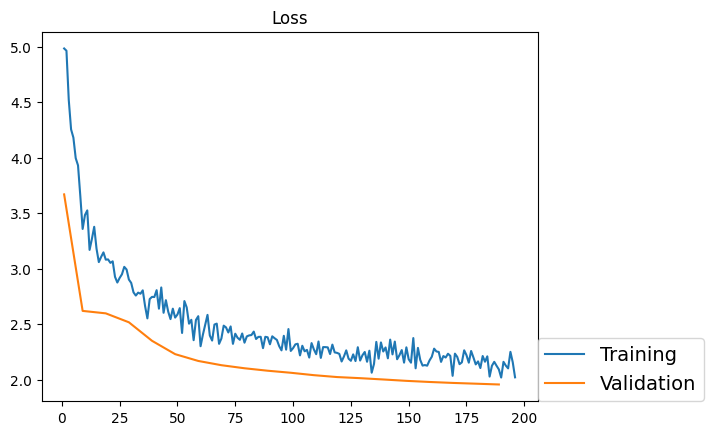

In [21]:
# Re-initialize weights
reset_parameters(model)

# Train with defaul settings.
train_loss_history = fit(model)

**Note:** The validation loss (on the unseen data) is overall *lower* than the training loss. This might initially seem like an unexpected behaviour, but it results from the fact that we use 50% Dropout during training, meaning that half of the weights of the fully connected layers are not used during training. When evaluating the model on the validation set, Dropout is disabled, and all weights are used. This leads to a better prediction (i.e., a lower loss) on the validation set.

###3.7 Performing quick experiments on reduced dataset
When searching for hyperparameters it is often useful to perform quick experiments on only a small subset of the data. You can do this by decreasing the batch size and setting `batches_per_epoch` to say 20. The effective size of the training set is then `bs*batches_per_epoch` (say `128*20 = 2,560`), and the total number of batches being processed during training is `bs*batches_per_epoch*epochs` (say `128*20*5 = 51,200`).


Epochs: 5 Batches per epoch: 20 Total number of batches 100
t 10 lr 0.001 train loss 3.12489 val loss 2.607508 val accuracy 0.0953125
t 20 lr 0.001 train loss 2.7449176 val loss 2.4753072 val accuracy 0.120312504
t 30 lr 0.001 train loss 2.9345863 val loss 2.395911 val accuracy 0.1296875
t 40 lr 0.001 train loss 2.4821055 val loss 2.3001075 val accuracy 0.15468751
t 50 lr 0.001 train loss 2.5388198 val loss 2.2301967 val accuracy 0.17812501
t 60 lr 0.001 train loss 2.5811617 val loss 2.1912713 val accuracy 0.203125
t 70 lr 0.001 train loss 2.3808193 val loss 2.1595275 val accuracy 0.2296875
t 80 lr 0.001 train loss 2.4530451 val loss 2.1338148 val accuracy 0.2375
t 90 lr 0.001 train loss 2.4514039 val loss 2.1119926 val accuracy 0.24843751
t 100 lr 0.001 train loss 2.3933814 val loss 2.0955298 val accuracy 0.275
[array(4.651899, dtype=float32), array(2.607508, dtype=float32), array(2.4753072, dtype=float32), array(2.395911, dtype=float32), array(2.3001075, dtype=float32), array(2.23019

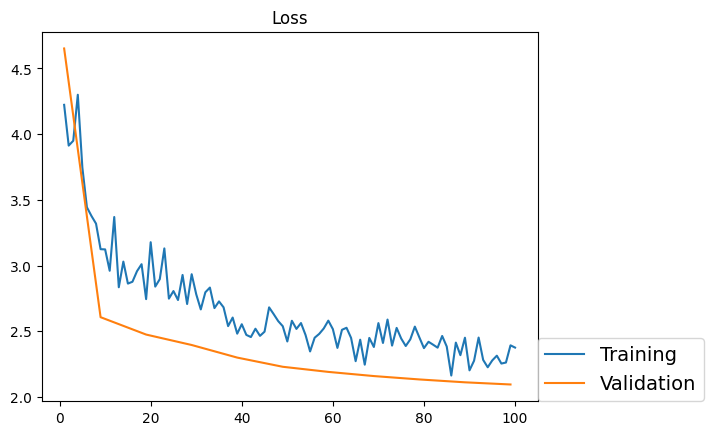

In [22]:
# Re-initialize weights
reset_parameters(model)

# Example: Train on small subset
train_loss_history = fit(model,bs=128,epochs=5,batches_per_epoch=20)

###3.7 Train with custom optimizer
Fell free to experiment with these optimizers.

Epochs: 5 Batches per epoch: 20 Total number of batches 100
t 10 lr 0.1 train loss 2.2234828 val loss 2.2107406 val accuracy 0.15
t 20 lr 0.1 train loss 2.1114123 val loss 2.12371 val accuracy 0.253125
t 30 lr 0.1 train loss 1.9933236 val loss 2.0543442 val accuracy 0.2515625
t 40 lr 0.1 train loss 2.0378623 val loss 2.032065 val accuracy 0.221875
t 50 lr 0.1 train loss 1.9600124 val loss 1.9567183 val accuracy 0.24062501
t 60 lr 0.1 train loss 1.8934221 val loss 1.8613831 val accuracy 0.31718752
t 70 lr 0.1 train loss 1.77043 val loss 1.8481165 val accuracy 0.29375002
t 80 lr 0.1 train loss 1.7027012 val loss 1.8705809 val accuracy 0.31875
t 90 lr 0.1 train loss 1.6940423 val loss 1.8221312 val accuracy 0.34375
t 100 lr 0.1 train loss 1.6393723 val loss 1.8135029 val accuracy 0.2890625
[array(3.5572884, dtype=float32), array(2.2107406, dtype=float32), array(2.12371, dtype=float32), array(2.0543442, dtype=float32), array(2.032065, dtype=float32), array(1.9567183, dtype=float32), array(

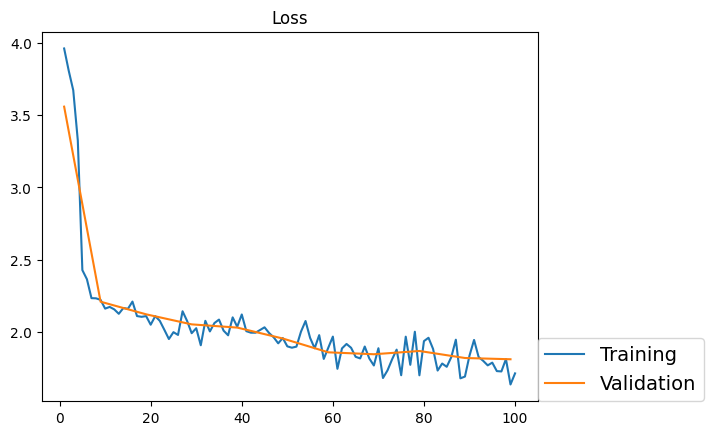

In [23]:
#SGD + Momentum
def momentum_optimizer(model):
    return optim.SGD(model.parameters(), lr=0.1, momentum=0.9)

# Adagrad
def adagrad_optimizer(model):
  return optim.Adagrad(model.parameters(), lr=0.1, lr_decay=0.0, weight_decay=0.0, initial_accumulator_value=0)

# RMSProp
def rmsprop_optimizer(model):
  return optim.RMSprop(model.parameters(), lr=0.1, alpha=0.99, eps=1e-08, weight_decay=0, momentum=0, centered=False)

# Adam
def adam_optimizer(model):
  return optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)

# Train with custom optimizer (on small subset)
reset_parameters(model) # Reset network weights
train_loss_history = fit(model,opt_func=momentum_optimizer,bs=128,epochs=5,batches_per_epoch=20)

##4. Tasks: You are free to choose any of the tasks below
The overall goal is to make the model perform as good as possible on the CIFAR 10 dataset. Solving the tasks below might help you, but feel free to try other options. For inspiration, here is a list of other things, you could do:

- **Increase the capacity of the network** (add more conv layers, add more kernels in each layer, add another fully connected layer, add more connections in the fully connected layer, etc.)
- **Experiment with weight decay** (weight decay is an option for, say, the [SGD optimizer](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html#torch.optim.SGD))

General recommendations for hyperparameter search (see Lecture 6 slides):
- Stage your search from course to fine
- Start with a small sample (subset) of the dataset to tune in on hyperparameters such as learning rate, and start with 1 epoch or less
- The second stage could then perform a narrower search with more data and/or more epochs
- Search for learning rates in powers of 10. Good learning rates to try: 1e-1, 1e-2, 1e-3, 1e-4, etc.)
- **Look at loss curves!!!**


###4.1 Implement a learning rate scheduler
**Your task** is to replace the function `base_lr_scheduler` with your own `step_decay` function (or another type of learning rate scheduler if you prefer). In step decay the lerning rate is updated for every `step` batches according to the rule `lr = lr * decay_rate`. The input `t` is the current batch index, ranging from 1 to `T`, where `T = batches_per_epoch * epochs` is the total number of batches.

**Solution:**

Epochs: 5 Batches per epoch: 20 Total number of batches 100
t 10 lr 0.1 train loss 2.2431817 val loss 2.242532 val accuracy 0.1640625
t 20 lr 0.09000000000000001 train loss 2.194848 val loss 2.144851 val accuracy 0.2234375
t 30 lr 0.08100000000000002 train loss 1.9181597 val loss 1.9830674 val accuracy 0.2421875
t 40 lr 0.07290000000000002 train loss 1.894257 val loss 1.9562546 val accuracy 0.30625
t 50 lr 0.06561000000000002 train loss 1.7540413 val loss 1.8932381 val accuracy 0.3109375
t 60 lr 0.05904900000000002 train loss 1.895097 val loss 1.7677954 val accuracy 0.33281252
t 70 lr 0.05314410000000002 train loss 1.7737982 val loss 1.7256527 val accuracy 0.359375
t 80 lr 0.04782969000000002 train loss 1.690282 val loss 1.6848444 val accuracy 0.3828125
t 90 lr 0.043046721000000024 train loss 1.6441058 val loss 1.6597115 val accuracy 0.3984375
t 100 lr 0.03874204890000002 train loss 1.509572 val loss 1.6317583 val accuracy 0.409375
[array(3.0424743, dtype=float32), array(2.242532, dtyp

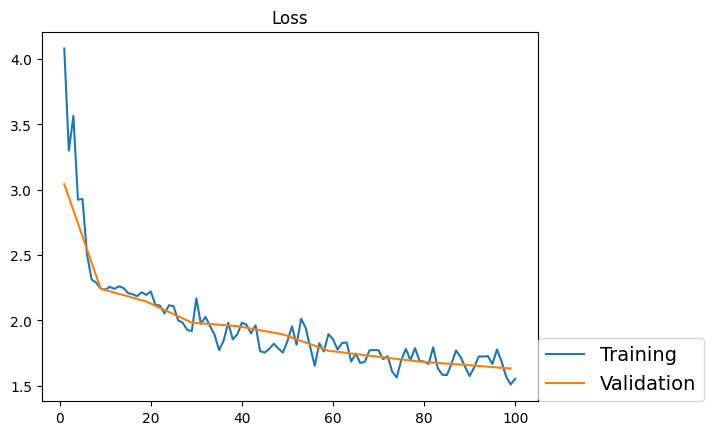

In [24]:
def step_decay(t,T,lr,step=10,decay_rate=0.9):
  if t % step == 0:
    lr = lr * decay_rate
  return lr

# Train
model = Net().cuda()
reset_parameters(model)
train_loss_history = fit(model,opt_func=momentum_optimizer,lr_scheduler=step_decay,bs=128,epochs=5,batches_per_epoch=20)

**Sub-tasks:**
- What new hyperparameters are added with learning rate decay?
- See if you can make the model perform better with learning rate decay.

**Comment/answer:**
- Two more hyperparameters are added: `step` and `decay_rate`

###4.2 Implement a learning rate finder
Finding a good initial learning rate can be done efficiently with a learning rate finder. Here is the basic idea:

You can modify the learning rate scheduler `base_lr_scheduler` to use a hardcoded list of learning rates. This can be used to implement a learning rate finder according to this principle:
- Start training and increase learning rate linearly after each batch (!!!), and calculate the loss
- Then display the loss as a function of learning rate.
- By manual inspection, select a suitable range of learning rates by locating the strongest downward slope.

Say the hardcoded learning rates are:

In [25]:
# Ordered list of learning rates (ascending order)
lr_list = [0.001,0.01,0.05,0.1]

Then simply implement a learning rate scheduler that returns the t´th entry of the learning rate list:

In [26]:
def lr_finder(t,T,lr):
  return lr_list[t-1]

Note, the learning rate scheduler must have this interface: `(t,T,lr)`

Then train the model for as many batches as there are entries in the learning rate list:

In [27]:
# Make sure that we process as many batches as there are learning rates in our list:
batches_per_epoch = len(lr_list)
epochs = 1

# Train
model = Net().cuda()
reset_parameters(model)
train_loss_history = fit(model,lr_scheduler=lr_finder,epochs=epochs,batches_per_epoch=batches_per_epoch,show_summary=False)

Epochs: 1 Batches per epoch: 4 Total number of batches 4


Plot the loss versus learning rate and inspect:

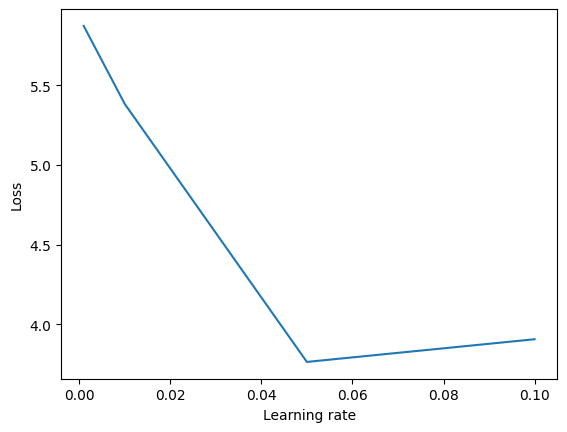

In [28]:
plt.figure()
plt.plot(lr_list,train_loss_history)
plt.xlabel('Learning rate');
plt.ylabel('Loss');

**Your task** is to implement a learning rate finder that searches through a range of learning rates, like above.

The range of learning rates should be logarithmic (say from 10^-6 to 10^0). You can define the list of learning rates using `np.logspace`.

Then plot the loss versus the learning rate. It is a good idea to use a logarithmic scale on the x-axis (see `plt.xscale('log')`).

####4.2.1 My solution

[1.00000000e-06 1.32571137e-06 1.75751062e-06 2.32995181e-06
 3.08884360e-06 4.09491506e-06 5.42867544e-06 7.19685673e-06
 9.54095476e-06 1.26485522e-05 1.67683294e-05 2.22299648e-05
 2.94705170e-05 3.90693994e-05 5.17947468e-05 6.86648845e-05
 9.10298178e-05 1.20679264e-04 1.59985872e-04 2.12095089e-04
 2.81176870e-04 3.72759372e-04 4.94171336e-04 6.55128557e-04
 8.68511374e-04 1.15139540e-03 1.52641797e-03 2.02358965e-03
 2.68269580e-03 3.55648031e-03 4.71486636e-03 6.25055193e-03
 8.28642773e-03 1.09854114e-02 1.45634848e-02 1.93069773e-02
 2.55954792e-02 3.39322177e-02 4.49843267e-02 5.96362332e-02
 7.90604321e-02 1.04811313e-01 1.38949549e-01 1.84206997e-01
 2.44205309e-01 3.23745754e-01 4.29193426e-01 5.68986603e-01
 7.54312006e-01 1.00000000e+00]
Epochs: 1 Batches per epoch: 50 Total number of batches 50
t 10 lr 9.540954763499944e-06 train loss 3.5453117 val loss 2.6707966 val accuracy 0.08713943
t 20 lr 0.00015998587196060574 train loss 3.4426188 val loss 2.666456 val accuracy 

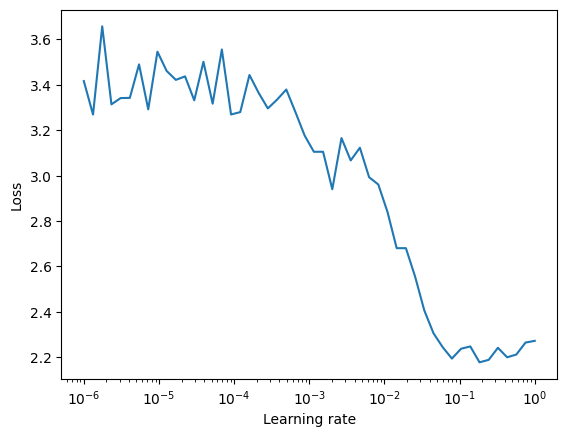

In [29]:
batches_per_epoch = 50
lr_list = np.logspace(-6,0,batches_per_epoch) # Your code goes here
print(lr_list)

# Run
model = Net().cuda()
reset_parameters(model)
train_loss_history = fit(model,lr_scheduler=lr_finder,epochs=epochs,batches_per_epoch=batches_per_epoch,show_summary=False)
plt.figure()
plt.plot(lr_list,train_loss_history)
plt.xscale('log') # Use log scale on x-axis
plt.xlabel('Learning rate');
plt.ylabel('Loss');

**Comments: What to look for?**
The numerical value of the loss is not important. What is important is the rate of change of the loss. So what we are looking for is the range of learning rates, where the loss decreases most rapidly. That seems to be somewhere between 10^-2 and 10^-1 (look for steepest slope).

**Additional sub-task:** Can you come up with a simple way to implement Cyclic Learning Rate (CLR) based on the above?

Hint: Run training multiple times using a carefully selected list of learning rates each time.

####4.2.2 My solution
Train 4 cycles, and in each cycle use 50 learning rates from 10^-2 to 10^-1.

Epochs: 1 Batches per epoch: 50 Total number of batches 50
t 10 lr 0.06866488450042998 train loss 2.249735 val loss 2.2194154 val accuracy 0.15715145
t 20 lr 0.04291934260128778 train loss 2.1213508 val loss 2.1376708 val accuracy 0.20973559
t 30 lr 0.02682695795279726 train loss 2.1017241 val loss 2.0822008 val accuracy 0.23227164
t 40 lr 0.016768329368110083 train loss 2.0914707 val loss 2.0614045 val accuracy 0.22716346
t 50 lr 0.010481131341546858 train loss 2.14205 val loss 2.0485044 val accuracy 0.25
[array(3.2470622, dtype=float32), array(2.2194154, dtype=float32), array(2.1376708, dtype=float32), array(2.0822008, dtype=float32), array(2.0614045, dtype=float32), array(2.0485044, dtype=float32)]


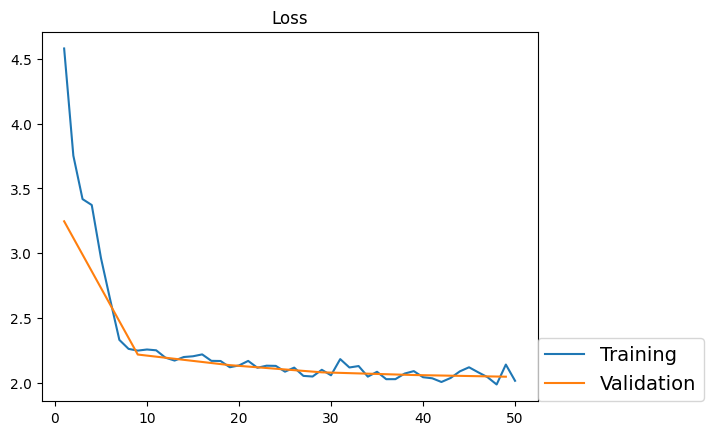

Epochs: 1 Batches per epoch: 50 Total number of batches 50
t 10 lr 0.06866488450042998 train loss 2.087219 val loss 2.0423677 val accuracy 0.24489184
t 20 lr 0.04291934260128778 train loss 1.9710205 val loss 1.9981495 val accuracy 0.28545675
t 30 lr 0.02682695795279726 train loss 2.067031 val loss 1.9673122 val accuracy 0.28695914
t 40 lr 0.016768329368110083 train loss 2.055428 val loss 1.9528842 val accuracy 0.30618992
t 50 lr 0.010481131341546858 train loss 1.9441897 val loss 1.9429246 val accuracy 0.31310096
[array(2.047407, dtype=float32), array(2.0423677, dtype=float32), array(1.9981495, dtype=float32), array(1.9673122, dtype=float32), array(1.9528842, dtype=float32), array(1.9429246, dtype=float32)]


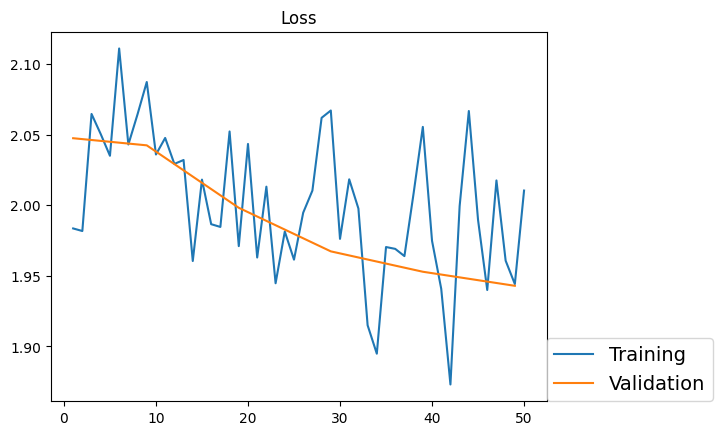

Epochs: 1 Batches per epoch: 50 Total number of batches 50
t 10 lr 0.06866488450042998 train loss 1.9555626 val loss 1.9095498 val accuracy 0.3158053
t 20 lr 0.04291934260128778 train loss 1.9669604 val loss 1.898025 val accuracy 0.3326322
t 30 lr 0.02682695795279726 train loss 1.8202035 val loss 1.8639612 val accuracy 0.32331732
t 40 lr 0.016768329368110083 train loss 1.9279854 val loss 1.8423866 val accuracy 0.3377404
t 50 lr 0.010481131341546858 train loss 1.84451 val loss 1.8251405 val accuracy 0.34435096
[array(1.9415187, dtype=float32), array(1.9095498, dtype=float32), array(1.898025, dtype=float32), array(1.8639612, dtype=float32), array(1.8423866, dtype=float32), array(1.8251405, dtype=float32)]


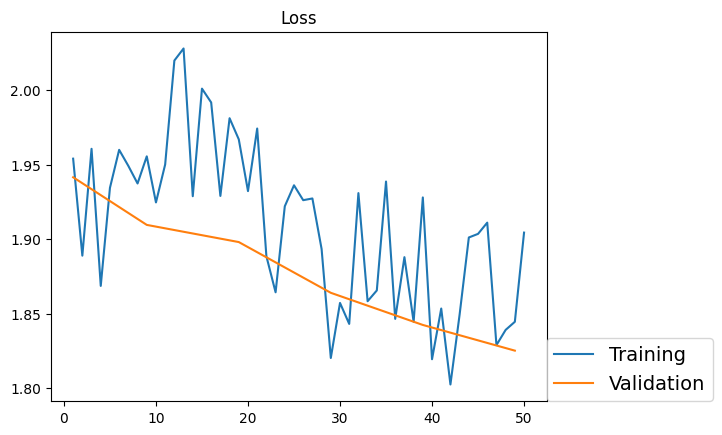

Epochs: 1 Batches per epoch: 50 Total number of batches 50
t 10 lr 0.06866488450042998 train loss 1.8441505 val loss 1.8260914 val accuracy 0.34435096
t 20 lr 0.04291934260128778 train loss 1.8705101 val loss 1.8043457 val accuracy 0.35306492
t 30 lr 0.02682695795279726 train loss 1.893466 val loss 1.7825809 val accuracy 0.36959136
t 40 lr 0.016768329368110083 train loss 1.8158739 val loss 1.7613287 val accuracy 0.35757214
t 50 lr 0.010481131341546858 train loss 1.7065246 val loss 1.7442998 val accuracy 0.36658657
[array(1.8239564, dtype=float32), array(1.8260914, dtype=float32), array(1.8043457, dtype=float32), array(1.7825809, dtype=float32), array(1.7613287, dtype=float32), array(1.7442998, dtype=float32)]


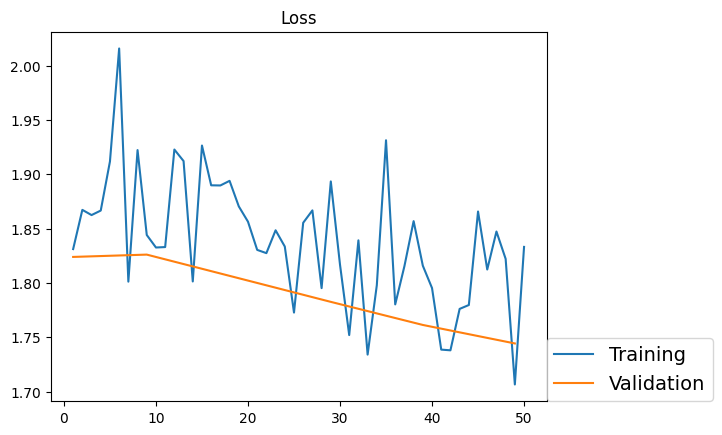

Epochs: 1 Batches per epoch: 50 Total number of batches 50
t 10 lr 0.06866488450042998 train loss 1.7640396 val loss 1.7448767 val accuracy 0.3671875
t 20 lr 0.04291934260128778 train loss 1.9009825 val loss 1.7150016 val accuracy 0.37229568
t 30 lr 0.02682695795279726 train loss 1.8605925 val loss 1.694518 val accuracy 0.38221157
t 40 lr 0.016768329368110083 train loss 1.7626926 val loss 1.6840909 val accuracy 0.3798077
t 50 lr 0.010481131341546858 train loss 1.7581686 val loss 1.6631887 val accuracy 0.39032453
[array(1.7435461, dtype=float32), array(1.7448767, dtype=float32), array(1.7150016, dtype=float32), array(1.694518, dtype=float32), array(1.6840909, dtype=float32), array(1.6631887, dtype=float32)]


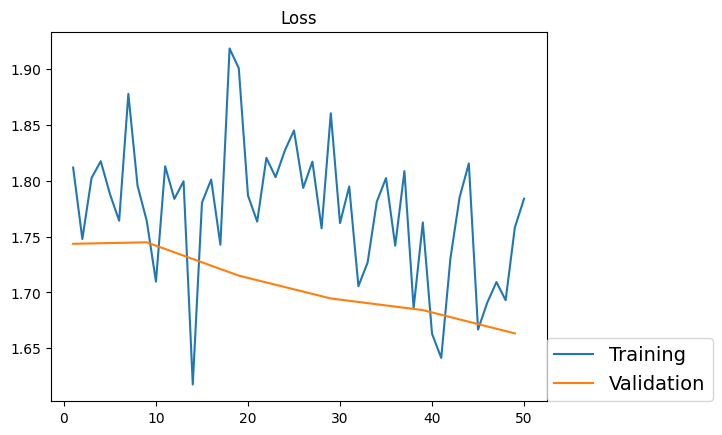

In [30]:
lr_list = np.logspace(-2,-1,50) # Learning rates in ascending order
lr_list = np.flip(lr_list,axis=0) # Learning rates in descending order
batches_per_epoch = len(lr_list)
epochs = 1

def CLR(t,T,lr):
  return lr_list[t-1]

reset_parameters(model)
for cycle in range(5):
  train_loss_history = fit(model,lr_scheduler=CLR,epochs=epochs,batches_per_epoch=batches_per_epoch)

###4.3 Experiment with dropout
Below is a slight modification of our model that allows changing the dropout fraction (p).

**Your task** is to experiment with different values of p.

- What does setting p = 0 mean?
- Try different values of p (say 0, 0.1, 0.5 and 0.9). What is the optimal value of p?

In [31]:
def Net(p=0.5):
  net = nn.Sequential(
      nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, stride=1, padding=0),
      nn.BatchNorm2d(num_features=6),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2, stride=2),
      nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5),
      nn.BatchNorm2d(num_features=16),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2, stride=2),
      Lambda(lambda x: x.view(x.size(0), -1)), # Vectorize
      nn.Dropout(p=p),
      nn.Linear(in_features=16*5*5,out_features=120),
      nn.ReLU(),
      nn.Linear(in_features=120, out_features=10)
  )
  return net

# Model with p=0.25
model = Net(p=0.25).cuda()

Epochs: 5 Batches per epoch: 20 Total number of batches 100
t 10 lr 0.001 train loss 2.623299 val loss 2.433138 val accuracy 0.096875004
t 20 lr 0.001 train loss 2.5396311 val loss 2.3378327 val accuracy 0.16250001
t 30 lr 0.001 train loss 2.287936 val loss 2.259705 val accuracy 0.1828125
t 40 lr 0.001 train loss 2.250981 val loss 2.2056606 val accuracy 0.18593751
t 50 lr 0.001 train loss 2.2130353 val loss 2.1670694 val accuracy 0.20625
t 60 lr 0.001 train loss 2.2315602 val loss 2.1184444 val accuracy 0.221875
t 70 lr 0.001 train loss 1.9916351 val loss 2.0766392 val accuracy 0.2375
t 80 lr 0.001 train loss 2.0825036 val loss 2.0546453 val accuracy 0.2515625
t 90 lr 0.001 train loss 1.9795316 val loss 2.0304039 val accuracy 0.246875
t 100 lr 0.001 train loss 1.9697137 val loss 2.0110297 val accuracy 0.26250002
[array(2.5762203, dtype=float32), array(2.433138, dtype=float32), array(2.3378327, dtype=float32), array(2.259705, dtype=float32), array(2.2056606, dtype=float32), array(2.1670

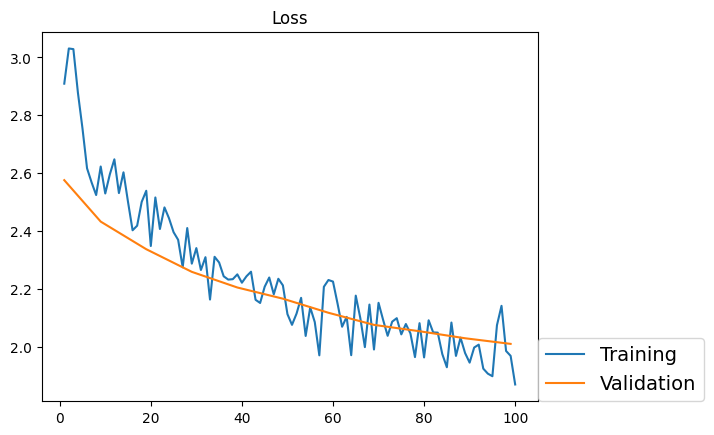

In [32]:
# p = 0 means no dropout
model = Net(p=0.0).cuda()
reset_parameters(model)
train_loss_history = fit(model,bs=128,epochs=5,batches_per_epoch=20)

Epochs: 5 Batches per epoch: 20 Total number of batches 100
t 10 lr 0.001 train loss 6.130638 val loss 2.6985168 val accuracy 0.0953125
t 20 lr 0.001 train loss 5.354366 val loss 2.711124 val accuracy 0.0984375
t 30 lr 0.001 train loss 4.2043037 val loss 2.56751 val accuracy 0.125
t 40 lr 0.001 train loss 3.8949351 val loss 2.4148896 val accuracy 0.1359375
t 50 lr 0.001 train loss 3.6649063 val loss 2.3168645 val accuracy 0.140625
t 60 lr 0.001 train loss 3.187342 val loss 2.2788117 val accuracy 0.15
t 70 lr 0.001 train loss 3.4974751 val loss 2.243909 val accuracy 0.165625
t 80 lr 0.001 train loss 3.1783478 val loss 2.2178345 val accuracy 0.1890625
t 90 lr 0.001 train loss 2.745763 val loss 2.1974695 val accuracy 0.1953125
t 100 lr 0.001 train loss 2.7306008 val loss 2.179838 val accuracy 0.2046875
[array(2.7574353, dtype=float32), array(2.6985168, dtype=float32), array(2.711124, dtype=float32), array(2.56751, dtype=float32), array(2.4148896, dtype=float32), array(2.3168645, dtype=flo

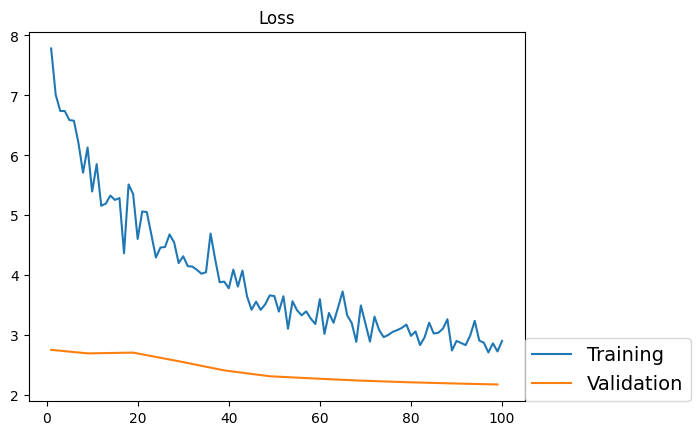

In [33]:
# p = 0.9 means "heavy dropout", which is in general a bad idea
model = Net(p=0.9).cuda()
reset_parameters(model)
train_loss_history = fit(model,bs=128,epochs=5,batches_per_epoch=20)

Epochs: 5 Batches per epoch: 20 Total number of batches 100
t 10 lr 0.001 train loss 2.6062753 val loss 2.4613335 val accuracy 0.1140625
t 20 lr 0.001 train loss 2.501015 val loss 2.37345 val accuracy 0.140625
t 30 lr 0.001 train loss 2.430753 val loss 2.3012283 val accuracy 0.165625
t 40 lr 0.001 train loss 2.272422 val loss 2.2149415 val accuracy 0.2140625
t 50 lr 0.001 train loss 2.104101 val loss 2.15965 val accuracy 0.246875
t 60 lr 0.001 train loss 2.1422248 val loss 2.1218116 val accuracy 0.253125
t 70 lr 0.001 train loss 2.0293338 val loss 2.0960636 val accuracy 0.2359375
t 80 lr 0.001 train loss 2.0383637 val loss 2.0634542 val accuracy 0.253125
t 90 lr 0.001 train loss 1.9552093 val loss 2.0376623 val accuracy 0.2734375
t 100 lr 0.001 train loss 2.1458113 val loss 2.0154243 val accuracy 0.2765625
[array(2.6675975, dtype=float32), array(2.4613335, dtype=float32), array(2.37345, dtype=float32), array(2.3012283, dtype=float32), array(2.2149415, dtype=float32), array(2.15965, dty

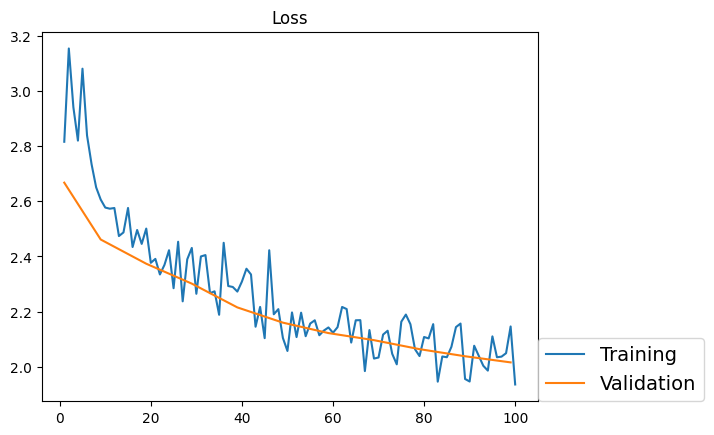

In [34]:
# p = 0.1
model = Net(p=0.1).cuda()
reset_parameters(model)
train_loss_history = fit(model,bs=128,epochs=5,batches_per_epoch=20)

###4.4 Data augmentation
Adding more training data is the best way to improve your models abiliy to generalize to unseen data. Data augmentations is basically about generating additional *fake data" to expand the size of your training set.

**Your task** is to experiment with different types of data augmentation. All you have to do is change the transformer below and add some of the available transforms: https://pytorch.org/vision/stable/transforms.html

You can find inspiration in Lab 5 (part 4): https://github.com/klaverhenrik/Deep-Learing-for-Visual-Recognition-2023/blob/main/Lab5_(part_4)_PyTorch_Transfer_Learning.ipynb


Files already downloaded and verified
Files already downloaded and verified
images.shape torch.Size([64, 3, 32, 32])


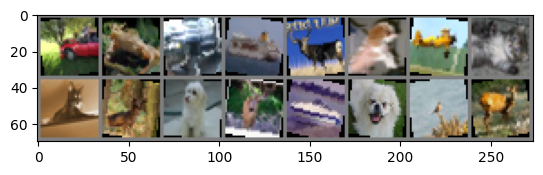

  car  frog truck  ship  deer   dog plane   cat   cat  deer   dog  deer  ship   dog  bird  deer


In [35]:
mean = 0.5
std = 0.5
transform = transforms.Compose(
    [ # My solution
      transforms.RandomHorizontalFlip(0.5), # Horizontally flip the given PIL Image randomly with a given probability.
      transforms.ColorJitter(brightness=0.1), # Randomly change the brightness, contrast and saturation of an image
      transforms.RandomRotation(degrees=15), # Rotate the image by angle.
      transforms.ToTensor(),
      transforms.Normalize((mean, mean, mean), (std, std, std))
     ])

# Batch size
bs = 64

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=bs,
                                          shuffle=True, num_workers=2,drop_last=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=bs,
                                         shuffle=False, num_workers=2,drop_last=True)

# Get a batch of some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)
print('images.shape',images.shape)

# show 10 images and print labels
imshow(torchvision.utils.make_grid(images[0:16]))
print(' '.join('%5s' % classes[labels[j]] for j in range(16)))

Epochs: 5 Batches per epoch: 20 Total number of batches 100
t 10 lr 0.001 train loss 3.153905 val loss 2.459691 val accuracy 0.0984375
t 20 lr 0.001 train loss 2.8858473 val loss 2.4910476 val accuracy 0.1375
t 30 lr 0.001 train loss 2.8569767 val loss 2.411041 val accuracy 0.1578125
t 40 lr 0.001 train loss 2.9838884 val loss 2.3494332 val accuracy 0.1640625
t 50 lr 0.001 train loss 2.446837 val loss 2.2544577 val accuracy 0.159375
t 60 lr 0.001 train loss 2.4926858 val loss 2.2020812 val accuracy 0.15625
t 70 lr 0.001 train loss 2.4325497 val loss 2.1772006 val accuracy 0.2
t 80 lr 0.001 train loss 2.4004452 val loss 2.1303413 val accuracy 0.1796875
t 90 lr 0.001 train loss 2.3173687 val loss 2.1189356 val accuracy 0.20156251
t 100 lr 0.001 train loss 2.352797 val loss 2.1123104 val accuracy 0.20625
[array(2.627843, dtype=float32), array(2.459691, dtype=float32), array(2.4910476, dtype=float32), array(2.411041, dtype=float32), array(2.3494332, dtype=float32), array(2.2544577, dtype=f

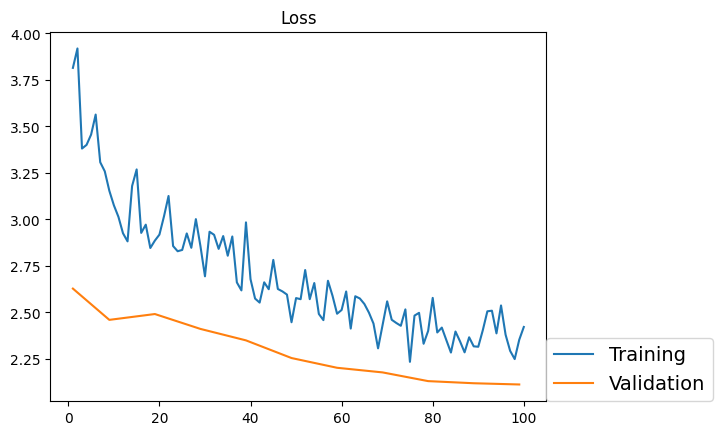

In [36]:
# Train
model = Net().cuda()
reset_parameters(model)
train_loss_history = fit(model,bs=128,epochs=5,batches_per_epoch=20)

###4.5 Multi-task learning (MTL)
By sharing representations between related tasks, we can enable our model to generalize better on our original task. This is the basic idea behind MTL.

There is one additional task that we can always add, and that is an **autoencoder**. Recall that an autoencoder is basically an identity function that maps input x to itself. It does so by first encoding x into a more compact representation E(x), and then decodes this representation to get a reconstruction of x = D(E(x)), where E() is the encoder, and D() is the decoder.

The network below uses the **same encoder** to solve both a **classification task** and an **autoencoder task**.

In [37]:
# define the NN architecture
class MTLNet(nn.Module):
    def __init__(self):
        super(MTLNet, self).__init__()

        ## shared encoder layers ##
        self.conv1 = nn.Conv2d(3, 16, 5, stride=2, padding=2)
        self.conv2 = nn.Conv2d(16, 4, 5, stride=2, padding=2)

        ## decoder layers ##
        # Classifier
        self.fc1 = nn.Linear(in_features=4*8*8, out_features=120)
        self.fc2 = nn.Linear(in_features=120, out_features=10)

        ## Autoencoder
        self.t_conv1 = nn.ConvTranspose2d(4, 16, 2, stride=2)
        self.t_conv2 = nn.ConvTranspose2d(16, 3, 2, stride=2)

    def forward(self, x):
        ## encode ##
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))

        # decoder for task 1 - outputs scores for classifier
        scores = x.view(-1, 4*8*8)
        scores = F.relu(self.fc1(scores))
        scores = self.fc2(scores)

        ## decoder for task 2 - outputs reconstruction of input x
        recon = F.relu(self.t_conv1(x))
        recon = self.t_conv2(recon)

        return scores, recon

# initialize the NN
model = MTLNet()

Let's look at the output of this model:

scores.shape torch.Size([64, 10])
recon.shape torch.Size([64, 3, 32, 32])

Input images:



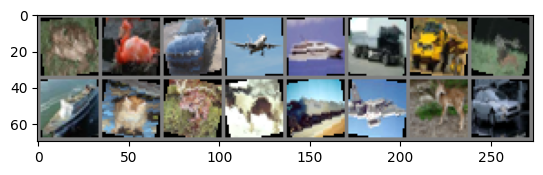

Reconstructed images:



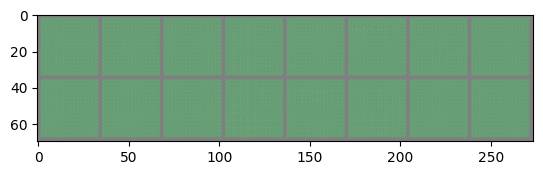

In [38]:
# Get a batch of some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

scores,recon = model(images)
print('scores.shape',scores.shape)
print('recon.shape',recon.shape)

# show 16 images and print labels
print('\nInput images:\n')
imshow(torchvision.utils.make_grid(images[0:16]))
print('Reconstructed images:\n')
imshow(torchvision.utils.make_grid(recon[0:16].detach().cpu()))

In order to optimize our MTL model we need a loss function. However, since we are solving two tasks, we also need two terms in our loss function - one for each task.

The loss for the classification task is the familiar cross entropy:

In [39]:
# Classification loss
loss_func_1 = F.cross_entropy
loss1 = loss_func_1(scores, labels)
print('Loss 1', loss1)

Loss 1 tensor(2.3058, grad_fn=<NllLossBackward0>)


A suitable loss for the autoencoder task would be the Mean Squared Error (MSE) between the input images (say `images`) and the networks reonstruction (say `recon`):

In [40]:
# MSE loss for reconstruction
loss_func_2 = F.mse_loss
loss2 = loss_func_2(images,recon)
print('Loss 2', loss2)

Loss 2 tensor(0.3425, grad_fn=<MseLossBackward0>)


Below is a modified function to fit the MTL model.

**Your task** is simply to fill in the missing code (marked with ???).

This is not as trivial as you might think (hint: do the two losses have the same scale?).

In [41]:
# Function to fit a model
def fit(model,
        opt_func=base_optimizer,
        lr_scheduler=base_lr_scheduler,
        bs=256,
        epochs=1,
        batches_per_epoch=None,
        show_summary=True):

  # Set up data loaders
  if batches_per_epoch == None:
    # Use all images
    train_dl = torch.utils.data.DataLoader(trainset, batch_size=bs,
                                          shuffle=True, num_workers=2)
    valid_dl = torch.utils.data.DataLoader(testset, batch_size=bs,
                                         shuffle=False, num_workers=2)
    batches_per_epoch = len(train_dl)
  else:
    # Only use a subset of the data
    subset_indices = list(range(batches_per_epoch*bs))
    train_dl = torch.utils.data.DataLoader(trainset, batch_size=bs, sampler=torch.utils.data.sampler.SubsetRandomSampler(subset_indices), num_workers=2)

    subset_indices = list(range(int(np.ceil(batches_per_epoch/4))*bs))
    valid_dl = torch.utils.data.DataLoader(testset, batch_size=bs, sampler=torch.utils.data.sampler.SubsetRandomSampler(subset_indices), num_workers=2)

  loss1_history = []
  loss2_history = []
  plot_time_train = []

  # Initialize optimizer
  opt = opt_func(model)

  t = 1 # Index of current batch
  T = batches_per_epoch * epochs # Total number of batches

  print('Epochs:',epochs,'Batches per epoch:',batches_per_epoch,'Total number of batches',T)

  # Train
  for epoch in range(epochs):
    model.train() # Train mode
    for xb, yb in train_dl:

      # Update learning rate
      opt.param_groups[0]['lr'] = lr_scheduler(t,T,lr=opt.param_groups[0]['lr'])

      # Forward prop
      scores,recon = model(xb.cuda())
      loss1 = loss_func_1(scores, yb.cuda())
      loss2 = loss_func_2(recon, xb.cuda())

      loss = loss1 + loss2

      if t % 10 == 0:    # print every 10 mini-batches
        print('loss1',loss1.detach().cpu().numpy(),'loss2',loss2.detach().cpu().numpy())

      loss1_history.append(loss1.detach().cpu().numpy())
      loss2_history.append(loss2.detach().cpu().numpy())
      plot_time_train.append(t)
      t += 1

      # Backward prop (calculate gradient)
      loss.backward()

      # Update model parameters
      opt.step()
      opt.zero_grad()

  # Summary
  if show_summary:
    plt.figure()
    lines = []
    labels = []
    l, = plt.plot(plot_time_train,loss1_history)
    lines.append(l)
    labels.append('Loss1 (classification)')
    l, = plt.plot(plot_time_train,loss2_history)
    lines.append(l)
    labels.append('Loss2 (autoencoder)')
    plt.title('Loss')
    plt.legend(lines, labels, loc=(1, 0), prop=dict(size=14))
    plt.show()

Epochs: 5 Batches per epoch: 20 Total number of batches 100
loss1 2.293616 loss2 0.29946074
loss1 2.318549 loss2 0.2632007
loss1 2.3089645 loss2 0.29313645
loss1 2.2992952 loss2 0.28510103
loss1 2.2833388 loss2 0.29072207
loss1 2.2957532 loss2 0.26380977
loss1 2.289472 loss2 0.2832256
loss1 2.2713916 loss2 0.26932275
loss1 2.2375007 loss2 0.27737373
loss1 2.2324803 loss2 0.30034828


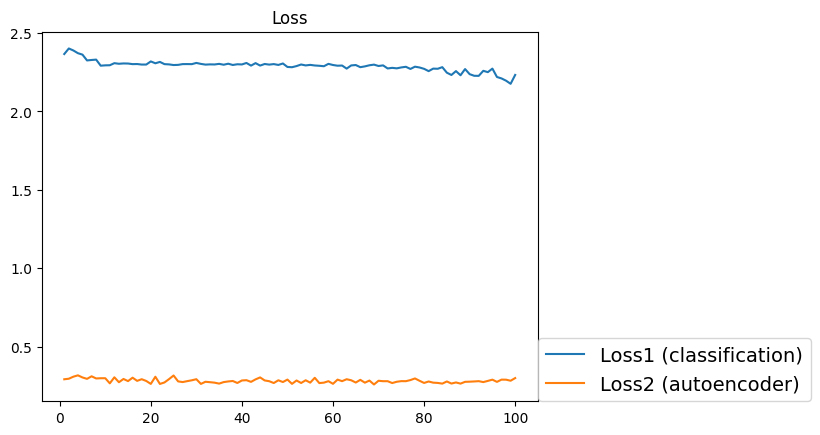

In [42]:
model = MTLNet().cuda()

# Re-initialize weights
reset_parameters(model)

def momentum_optimizer(model):
    return optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# Example (in practise you need more epochs than 5)
train_loss_history = fit(model,opt_func=momentum_optimizer,bs=128,epochs=5,batches_per_epoch=20)

**Comments:**
- Here I set loss = loss1 + loss2, but clearly loss1 is much higher than loss2.
- To balance them out we could set loss = loss1 + 10*loss2:

In [43]:
# Function to fit a model
def fit(model,
        opt_func=base_optimizer,
        lr_scheduler=base_lr_scheduler,
        bs=256,
        epochs=1,
        batches_per_epoch=None,
        show_summary=True):

  # Set up data loaders
  if batches_per_epoch == None:
    # Use all images
    train_dl = torch.utils.data.DataLoader(trainset, batch_size=bs,
                                          shuffle=True, num_workers=2)
    valid_dl = torch.utils.data.DataLoader(testset, batch_size=bs,
                                         shuffle=False, num_workers=2)
    batches_per_epoch = len(train_dl)
  else:
    # Only use a subset of the data
    subset_indices = list(range(batches_per_epoch*bs))
    train_dl = torch.utils.data.DataLoader(trainset, batch_size=bs, sampler=torch.utils.data.sampler.SubsetRandomSampler(subset_indices), num_workers=2)

    subset_indices = list(range(int(np.ceil(batches_per_epoch/4))*bs))
    valid_dl = torch.utils.data.DataLoader(testset, batch_size=bs, sampler=torch.utils.data.sampler.SubsetRandomSampler(subset_indices), num_workers=2)

  loss1_history = []
  loss2_history = []
  plot_time_train = []

  # Initialize optimizer
  opt = opt_func(model)

  t = 1 # Index of current batch
  T = batches_per_epoch * epochs # Total number of batches

  print('Epochs:',epochs,'Batches per epoch:',batches_per_epoch,'Total number of batches',T)

  # Train
  for epoch in range(epochs):
    model.train() # Train mode
    for xb, yb in train_dl:

      # Update learning rate
      opt.param_groups[0]['lr'] = lr_scheduler(t,T,lr=opt.param_groups[0]['lr'])

      # Forward prop
      scores,recon = model(xb.cuda())
      loss1 = loss_func_1(scores, yb.cuda())
      loss2 = 10 * loss_func_2(recon, xb.cuda())

      loss = loss1 + loss2

      if t % 10 == 0:    # print every 10 mini-batches
        print('loss1',loss1.detach().cpu().numpy(),'loss2',loss2.detach().cpu().numpy())

      loss1_history.append(loss1.detach().cpu().numpy())
      loss2_history.append(loss2.detach().cpu().numpy())
      plot_time_train.append(t)
      t += 1

      # Backward prop (calculate gradient)
      loss.backward()

      # Update model parameters
      opt.step()
      opt.zero_grad()

  # Summary
  if show_summary:
    plt.figure()
    lines = []
    labels = []
    l, = plt.plot(plot_time_train,loss1_history)
    lines.append(l)
    labels.append('Loss1 (classification)')
    l, = plt.plot(plot_time_train,loss2_history)
    lines.append(l)
    labels.append('Loss2 (autoencoder)')
    plt.title('Loss')
    plt.legend(lines, labels, loc=(1, 0), prop=dict(size=14))
    plt.show()

Epochs: 5 Batches per epoch: 20 Total number of batches 100
loss1 2.3010693 loss2 3.0562875
loss1 2.3099198 loss2 2.8576708
loss1 2.2962666 loss2 2.9230022
loss1 2.2538567 loss2 2.7558403
loss1 2.267425 loss2 2.6929932
loss1 2.2351403 loss2 2.912048
loss1 2.2391691 loss2 3.0006242
loss1 2.1572657 loss2 2.4143384
loss1 2.1693506 loss2 2.1259437
loss1 2.3448527 loss2 1.5172058


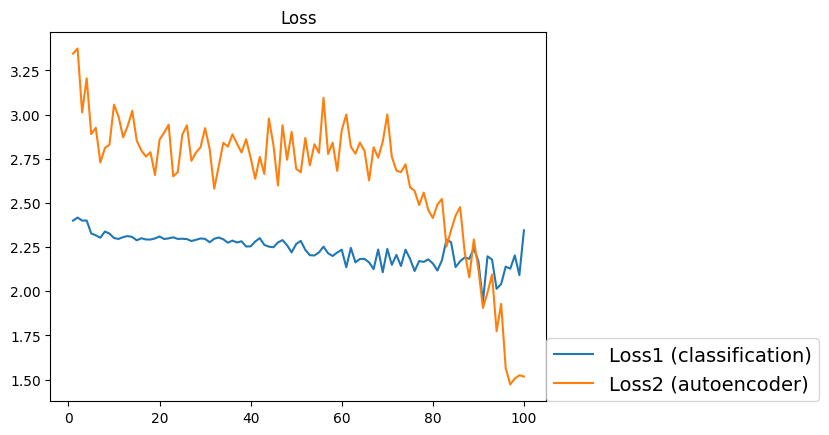

In [44]:
model = MTLNet().cuda()

# Re-initialize weights
reset_parameters(model)

def momentum_optimizer(model):
    return optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# Example (in practise you need more epochs than 5)
train_loss_history = fit(model,opt_func=momentum_optimizer,bs=128,epochs=5,batches_per_epoch=20)

**Comment:** Looks better! Now, train for more epochs.

Epochs: 50 Batches per epoch: 20 Total number of batches 1000
loss1 2.1653085 loss2 1.4466419
loss1 2.0743954 loss2 1.2981501
loss1 1.9666052 loss2 1.1555132
loss1 1.9027498 loss2 1.1306924
loss1 1.8909328 loss2 1.1195375
loss1 1.8670745 loss2 1.0551765
loss1 1.9916672 loss2 0.97461396
loss1 1.8382843 loss2 1.0297298
loss1 1.8745416 loss2 1.0116824
loss1 1.8772801 loss2 0.9817624
loss1 1.7756685 loss2 0.9950936
loss1 1.8749652 loss2 0.9196078
loss1 1.8898622 loss2 0.88386506
loss1 1.7934465 loss2 0.81471026
loss1 1.7512928 loss2 0.8168486
loss1 1.8632653 loss2 0.80335677
loss1 1.5474244 loss2 0.77998346
loss1 1.836986 loss2 0.77977586
loss1 1.7467784 loss2 0.81737936
loss1 1.8497146 loss2 0.7521807
loss1 1.6217155 loss2 0.7537062
loss1 1.6970761 loss2 0.7420869
loss1 1.9487665 loss2 0.73783183
loss1 1.8183942 loss2 0.7100779
loss1 1.6718003 loss2 0.68615854
loss1 1.6120028 loss2 0.70220447
loss1 1.6476874 loss2 0.6591386
loss1 1.6634378 loss2 0.7080202
loss1 1.5509105 loss2 0.65503895


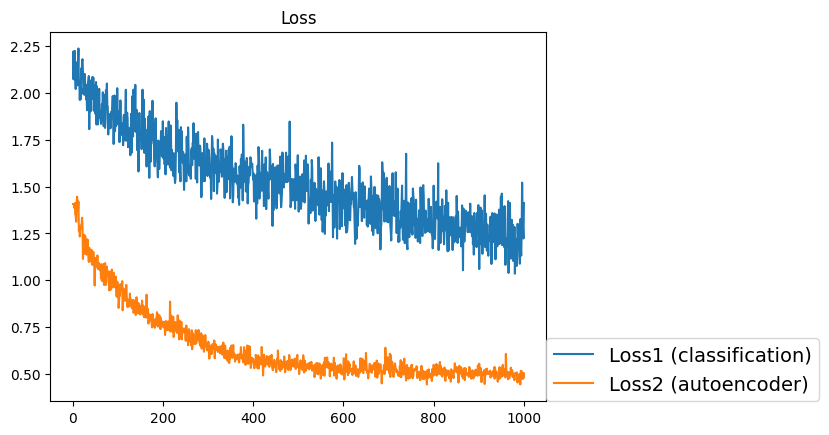

In [45]:
train_loss_history = fit(model,opt_func=momentum_optimizer,bs=128,epochs=50,batches_per_epoch=20)

We should probably train for longer, but let's evaluate:

accuracy tensor(0.4305, device='cuda:0')

Input images:



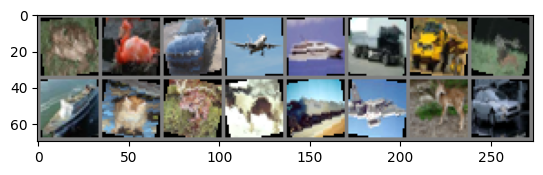

Reconstructed images:



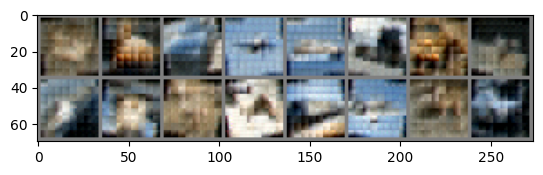

In [46]:
scores,recon = model(images.cuda())

# validation accuracy
acc = 0
for xb, yb in testloader:
  scores,recon_dummy = model(xb.cuda())
  acc += accuracy(scores,yb.cuda())
print('accuracy',acc/len(testloader))

# show 16 images and print labels
print('\nInput images:\n')
imshow(torchvision.utils.make_grid(images[0:16]))
print('Reconstructed images:\n')
imshow(torchvision.utils.make_grid(recon[0:16].detach().cpu()))